# About Project
* Predictive maintenance models to predict device failure which can help redusing costs of maintenance.

In [1]:
from utils import *

## Loading  dataset 

In [2]:
df = pd.read_csv('Data/train.csv')
# pandas_profiling.ProfileReport(df)

### Data explanation

In [3]:
df.Date = pd.to_datetime(df.Date)
df['Activedays']=df.Date-df.Date[0]
df['Month']=df['Date'].dt.month
df['Week_day']=df.Date.dt.weekday
df['Week_day'].replace(0,7,inplace=True)

In [4]:
season = []
for dt in df.Date:
    if dt < datetime(2020,3,1):
        season.append('winter')
    elif dt < datetime(2020,6,1):
        season.append('spring')
    elif dt<datetime(2020,9,1):
        season.append('summer')
    else:
        season.append('fall')

df['Season']=season
df.head()

,Unnamed: 0,Date,Device_ID,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,Sensor6,Sensor7,Sensor8,Sensor9,Fail,Activedays,Month,Week_day,Season
0,0,2020-01-01,Radar1Dt62,215630672,56,0,52,6,407438,0,0,7,0,0 days,1,2,winter
1,1,2020-01-01,Radar1kP80,61370680,0,3,0,6,403174,0,0,0,0,0 days,1,2,winter
2,2,2020-01-01,Radar1yG70,173295968,0,0,0,12,237394,0,0,0,0,0 days,1,2,winter
3,3,2020-01-01,Radar1Uz94,79694024,0,0,0,6,410186,0,0,0,0,0 days,1,2,winter
4,4,2020-01-01,Radar1mn65,135970480,0,0,0,15,313173,0,0,3,0,0 days,1,2,winter


<AxesSubplot: xlabel='Week_day'>

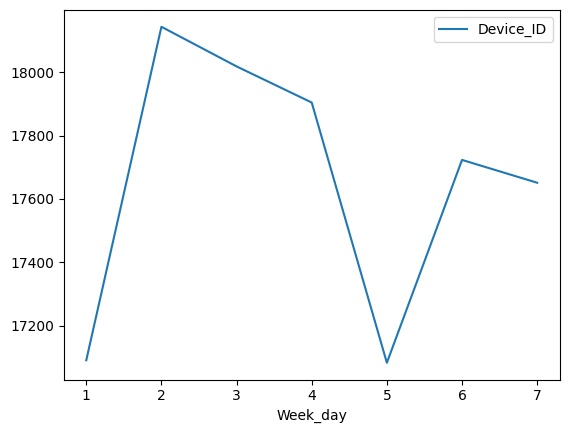

In [5]:
# Count of devices for each month
plt.show()
df.groupby('Week_day').agg({'Device_ID':lambda x: x.nunique()}).plot()

### Data visualization 

[]

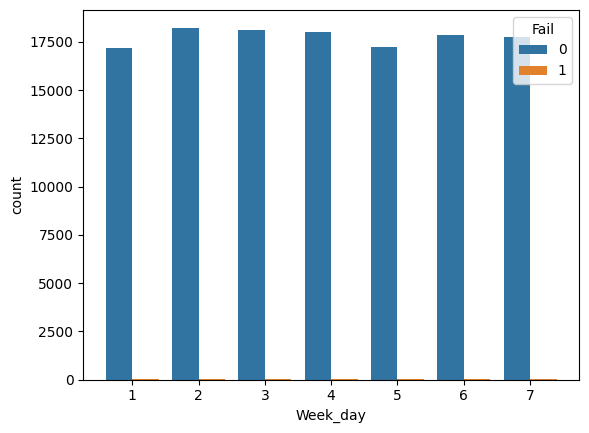

In [6]:
# Failed devices number per month
ax = sns.countplot(x="Week_day", hue="Fail", data=df)
ax.plot()

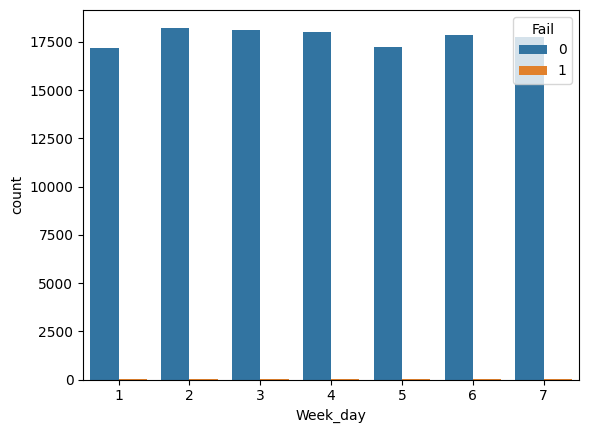

In [7]:
# Failed devices number per week day
ax = sns.countplot(x='Week_day',hue='Fail',data=df)

### Fixed Devices

In [8]:
df_date = df.groupby('Device_ID').agg({'Date':max})
df_date.Date.to_dict()
df_failure = df.loc[df.Fail==1,['Device_ID','Date']]
df_good = df.loc[df.Fail==0,['Device_ID','Date']]
df['max_date']=df.Device_ID.map(df_date.Date.to_dict())
dff=df[(df.Fail==1)&(df.Date!=df.max_date)]

## Reduce data set with unique device id

In [9]:
df1 = df.groupby('Device_ID').agg({'Date':max})
df1=df1.reset_index()
df=df.reset_index(drop=True) 
df2= pd.merge(df1,df,how='left',on=['Device_ID','Date'])

## Redefine device Id value

<AxesSubplot: xlabel='Device_ID', ylabel='count'>

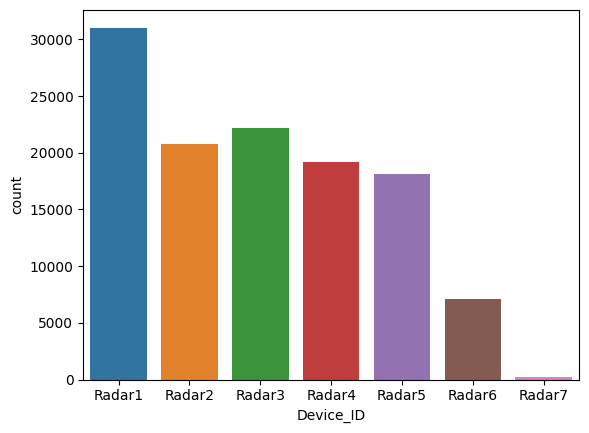

In [10]:
#change device id values to the first six characters

Id = df2.Device_ID.values.tolist()
Id1 = [] 
for i in Id:
    i = i[:6]
    Id1.append(i)
df2.Device_ID=Id1
df2.Device_ID.value_counts()
sns.countplot(x='Device_ID',data=df2)

## Data transformation

In [11]:
#redefine data type for some of the numerical features
cat_ftrs = ['Sensor3','Sensor4', 'Sensor5', 'Sensor7', 'Sensor9'] 
for col in cat_ftrs:
    df2[col]=df2[col].astype('object')

In [12]:
df2.Activedays = df2.Activedays.astype('str')
df2.Activedays=df2.Activedays.apply(str_to_num)
df2.Activedays = df2.Activedays.astype('int')

In [13]:
for col in ['Month','Week_day', 'Season']:
    df2[col]=df2[col].astype('object')

In [14]:
#numerical features standardization
scaler = StandardScaler()
num_ftrs =['Sensor1','Sensor2','Sensor6'] 
df2[num_ftrs]=scaler.fit_transform(df2[num_ftrs])

## Drop unimportant and redundant features 

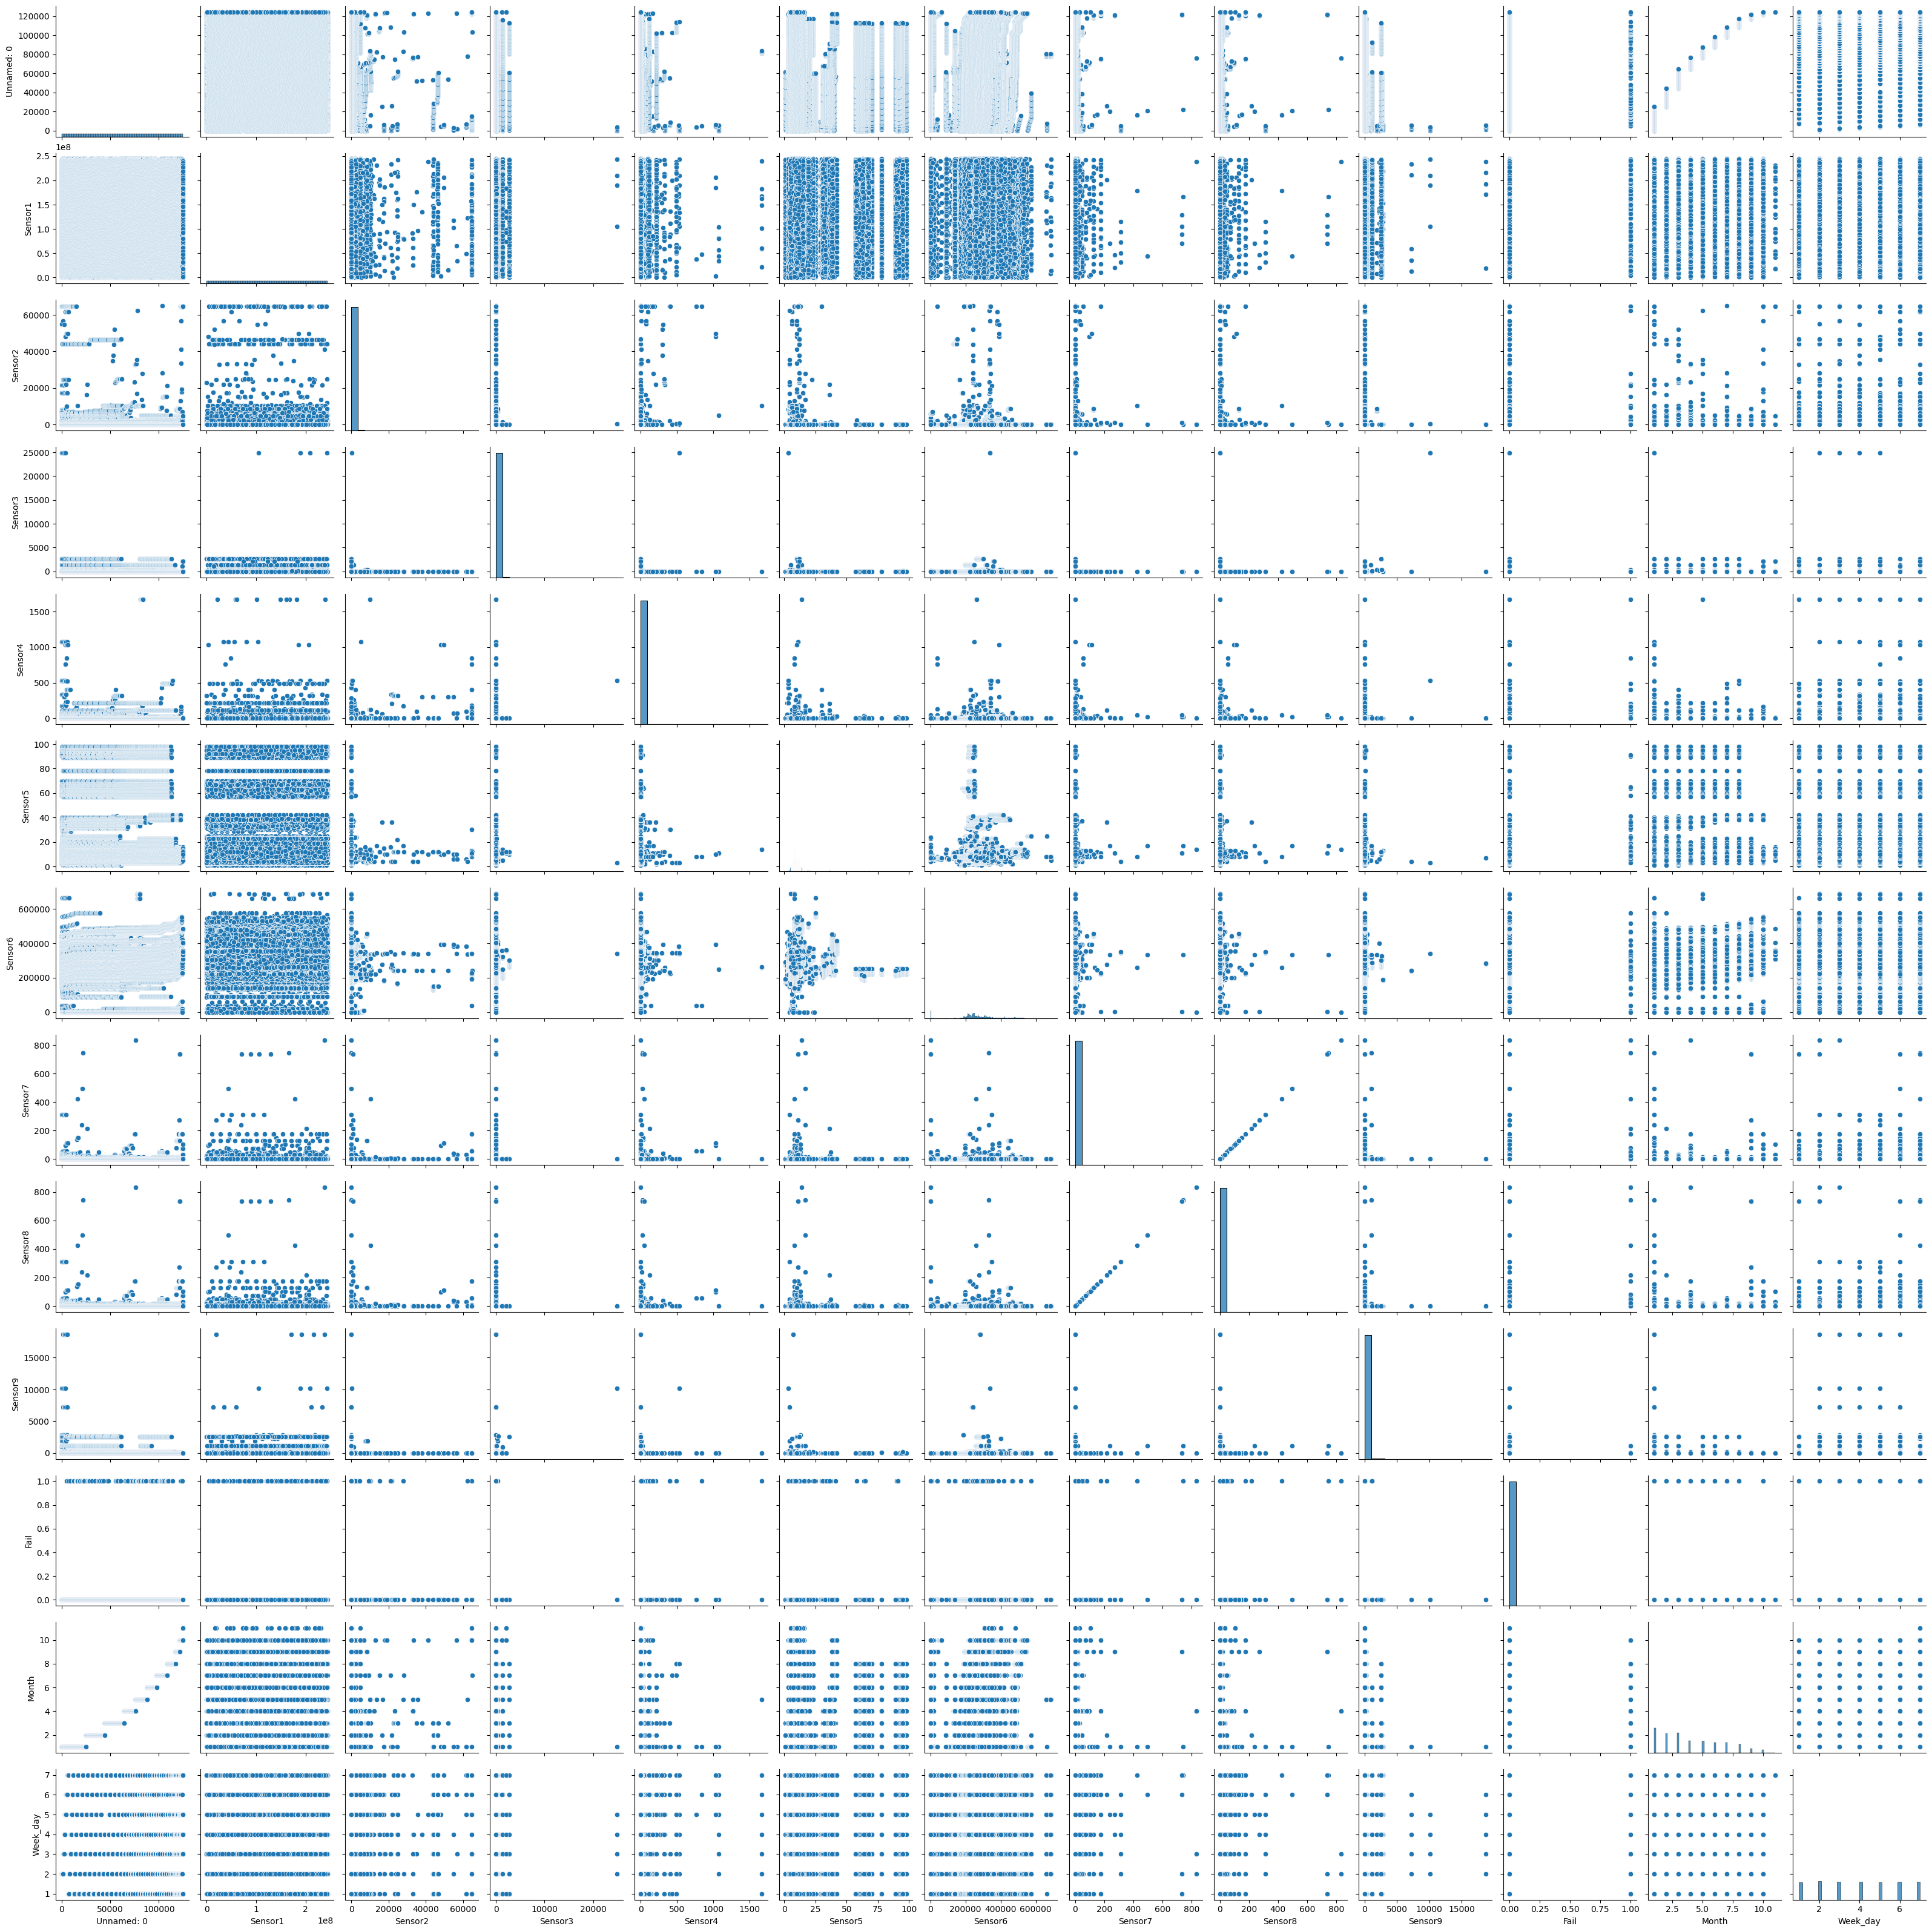

In [15]:
sns.pairplot(df)

In [16]:
# Sensor7 and Sensor8 is highly linear related or equal to each other
df.drop('Sensor8',axis=1,inplace=True)
df = df.reset_index(drop=True)
df.drop('Unnamed: 0', axis=1, inplace=True)

In [17]:
df2.drop(['Date','max_date'], axis=1, inplace=True)

In [18]:
# One hot encoding
df2 = pd.get_dummies(df2, drop_first=True)

# Feature Selection

## Define dependent and independent values

In [19]:
X = df2.drop('Fail',axis=1)
Y = df2.Fail

## Feature Selection

<AxesSubplot: ylabel='feature'>

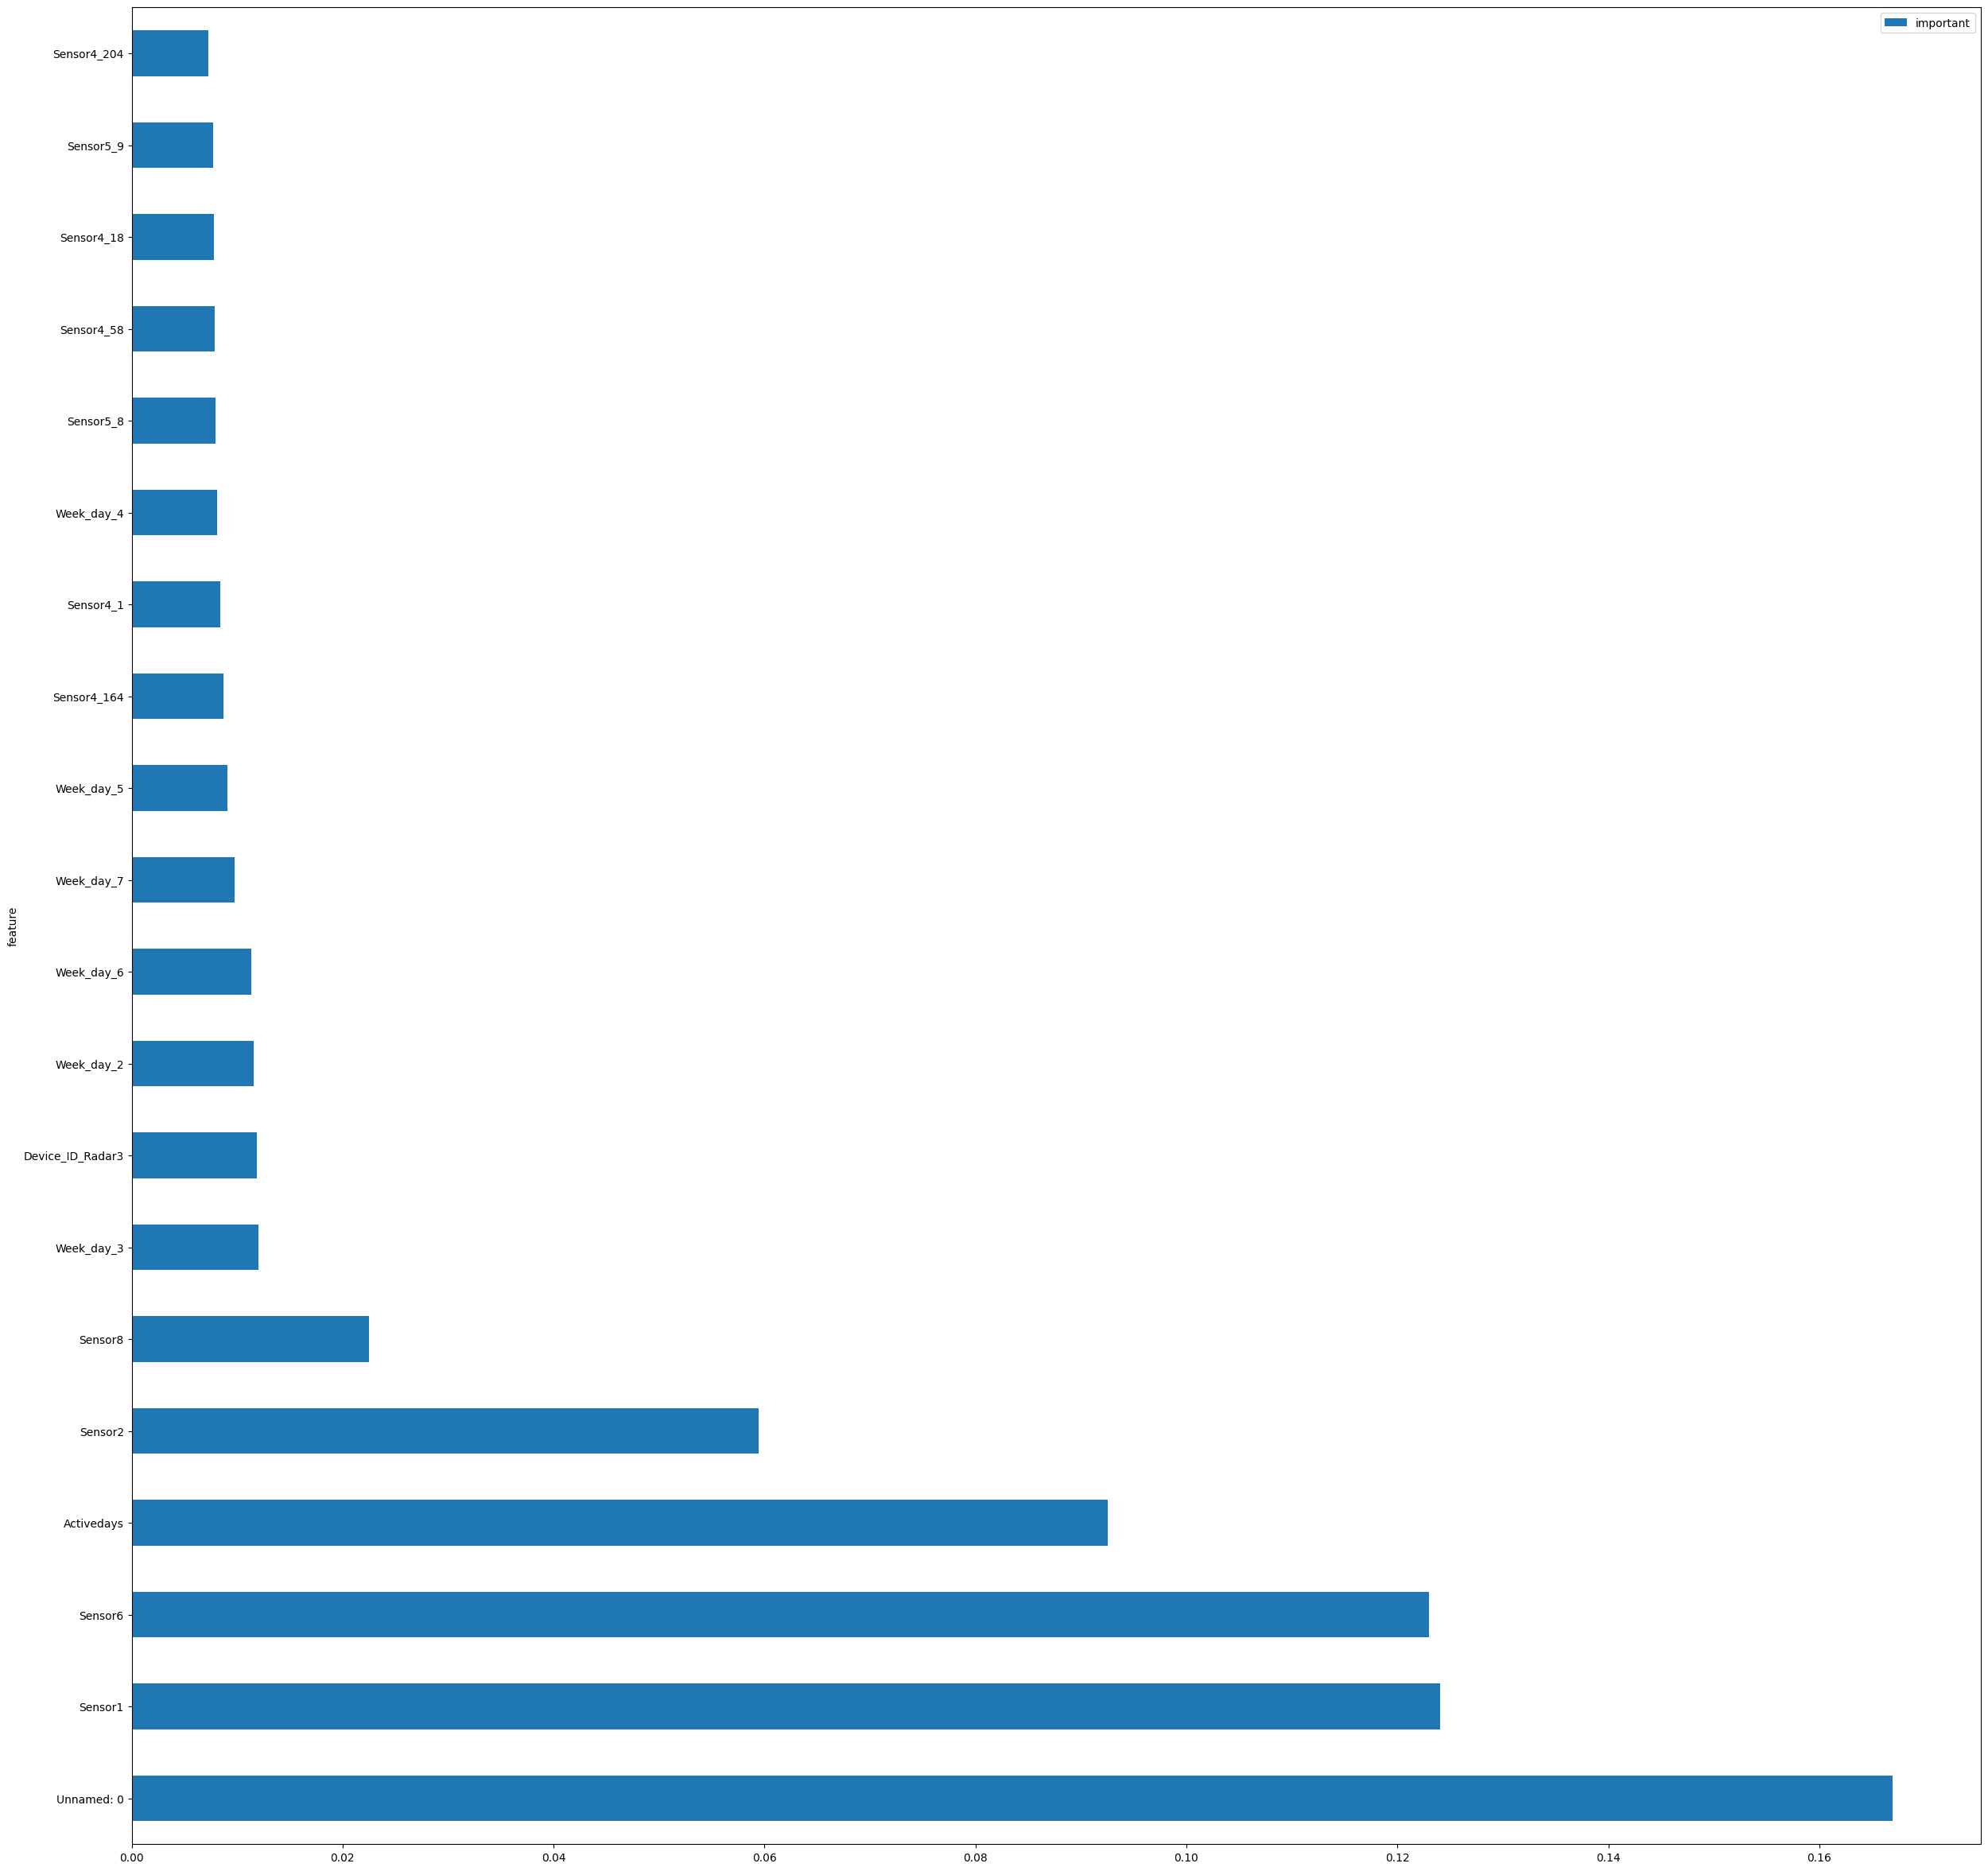

In [20]:
# Select features using RFC
clf = RandomForestClassifier(n_estimators=50, max_features='auto')
clf= clf.fit(X,Y)

features = pd.DataFrame()
features['feature'] = X.columns
features['important'] = clf.feature_importances_
features.sort_values(by=['important'], ascending=False,inplace=True)
features.set_index('feature', inplace=True)
features.iloc[:20,:].plot(kind='barh', figsize=(30,30))

In [21]:
# Selects important features 
model = SelectFromModel(clf,prefit=True)
x_reduced = model.transform(X)
x_reduced=pd.DataFrame(x_reduced)

In [22]:
# tested on RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(x_reduced, Y, train_size=0.8, random_state=42)
ros = RandomOverSampler(random_state=42)
#With new training data, upsample the failed devices using the RandomOverSampler. This method object to over-sample the minority class(es) by picking samples at random with replacement.

X_res, y_res = ros.fit_resample(X_train, y_train)
X_res.shape

X_res = pd.DataFrame(X_res)
#After upsampling, build a random forest model to classify the failed devices.

rf = RandomForestClassifier(n_estimators=5000, random_state=21)
rf.fit(X_res,y_res)

rf_test_pred = rf.predict(X_test)
rf_test_cm = confusion_matrix(y_test, rf_test_pred)
rf_test_cm
accuracy_score(y_test, rf_test_pred)
print(classification_report_imbalanced(y_test,rf_test_pred))

# pre is precision, which is a measure of result relevancy;
# rec is recall, which is the same as sensitivity. Recall is a measure of how many truly relevant results are returned;
# spe is specificity;
# f1 is the harmonic average of the precision and recall;
# geo(Matthews correlation coefficient) is the geometric mean of specificity and sensitivity;
# iba is the index of imbalanced accuracy

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      0.00      1.00      0.00      0.00     23738
          1       0.00      0.00      1.00      0.00      0.00      0.00        15

avg / total       1.00      1.00      0.00      1.00      0.00      0.00     23753



# Model Training

In [23]:
log_reg = LogisticRegression()
knn = KNeighborsClassifier()
grad_boost = GradientBoostingClassifier()
random_forest_regr = RandomForestRegressor(n_estimators=100)
svm = SVC()
random_forest_cls = RandomForestClassifier(n_estimators=10)
xg_boost = XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,\
                    hidden_layer_sizes=(5, 2), random_state=1)
algorithms = [knn,log_reg,grad_boost,random_forest_regr,svm, random_forest_cls,xg_boost,clf]
names = ['KNeighborsClassifier','Logistic','GradientBoost','RandomForest','SVC','RandomForestCl','xgboost','neunet']

iba = make_index_balanced_accuracy(alpha=0.1, squared=True)(geo)

In [24]:
cross_val_fit_pred(X_train, y_train, algorithms=algorithms, names=names, ros=ros)

[00:11:31] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[00:11:32] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[00:11:32] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[00:11:32] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[00:11:32] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


,Accuracy,geo_score,f1,recall,prec
Logistic,0.906640,0.680480,0.480767,0.725538,0.005512
GradientBoost,0.960383,0.678371,0.500250,0.722312,0.010593
SVC,0.508173,0.582795,0.337430,0.592984,0.001199
xgboost,0.950226,0.575319,0.493676,0.657723,0.006566
KNeighborsClassifier,0.997590,0.099910,0.507553,0.511720,0.012444
RandomForest,0.998537,0.049987,0.507041,0.505950,0.018182
RandomForestCl,0.999084,0.000000,0.499771,0.499979,0.000000
neunet,0.999126,0.000000,0.499782,0.500000,0.000000


## Model evaluation

In [25]:
# X_test=X_test.to_numpy()

# y_test=y_test.to_numpy()
probs1 = knn.predict_proba(X_test)
probs2 = xg_boost.predict_proba(X_test)
probs3 = grad_boost.predict_proba(X_test)
probs4 = random_forest_cls.predict_proba(X_test)
probs1 = probs1[:,1]
probs2 = probs2[:,1]
probs3 = probs3[:,1]
probs4 = probs4[:,1]

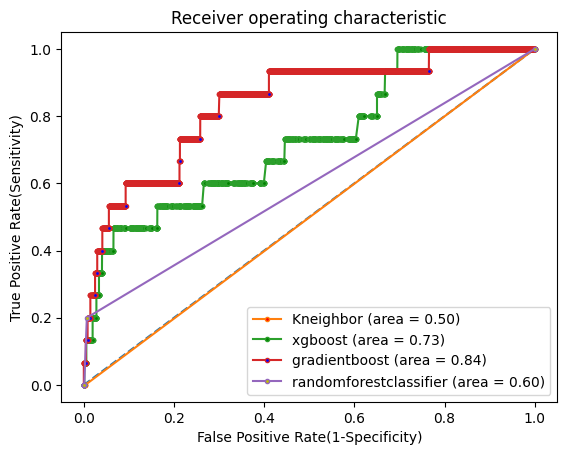

In [26]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, probs1)
fpr2, tpr2, thresholds2 = roc_curve(y_test, probs2)
fpr3, tpr3, thresholds3 = roc_curve(y_test, probs3)
fpr4, tpr4, thresholds4 = roc_curve(y_test, probs4)
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr1, tpr1, marker='.', markerfacecolor='r',label='Kneighbor (area = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, marker='.', markerfacecolor='g',label='xgboost (area = %0.2f)' % roc_auc2)
plt.plot(fpr3, tpr3, marker='.', markerfacecolor='b',label='gradientboost (area = %0.2f)' % roc_auc3)
plt.plot(fpr4, tpr4, marker='.',markerfacecolor='y',label='randomforestclassifier (area = %0.2f)' % roc_auc4)
plt.xlabel('False Positive Rate(1-Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [27]:
print("Geometric acc on test data with KNN", geo(y_test, knn.predict(X_test).round(2)))
print("Geometric acc on test data with Grad boost", geo(y_test, grad_boost.predict(X_test).round(2)))
print("Geometric acc on test data with SVM", geo(y_test, svm.predict(X_test).round(2)))
print("Geometric acc on test data with MLPClassifier", geo(y_test, clf.predict(X_test).round(2)))
print("Geometric acc on test data with XGBoost regressor", geo(y_test, xg_boost.predict(X_test).round(2)))
print("Geometric acc on test data with Random Forest classifier", geo(y_test, random_forest_cls.predict(X_test).round(2)))

Geometric acc on test data with KNN 0.0
Geometric acc on test data with Grad boost 0.6683510050640864
Geometric acc on test data with SVM 0.5612935162960228
Geometric acc on test data with MLPClassifier 0.0
Geometric acc on test data with XGBoost regressor 0.6141944426477594
Geometric acc on test data with Random Forest classifier 0.0


In [28]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

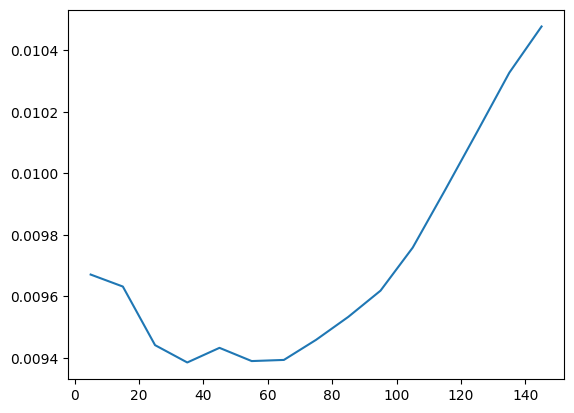

In [29]:
Geo1=[]
estimators = [i for i in range(5,150,10)]
Learning_rate = [i for i in np.arange(0.05,0.4,0.03)]
geo_score = []
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
for i in estimators:
    for train_index,test_index in kf.split(X_train, y_train):
        xtr,xvd=X_train[train_index],X_train[test_index]
        ytr,yvd=y_train[train_index],y_train[test_index]
        xtr_res,ytr_res=ros.fit_resample(xtr, ytr)
        gbc =GradientBoostingClassifier(n_estimators=i).fit(xtr_res,ytr_res)
        y_pred_test = gbc.predict(xvd).round()
        geo_score.append(precision_score(yvd, y_pred_test))
    Geo1.append(np.mean(geo_score))
plt.plot(estimators,Geo1)

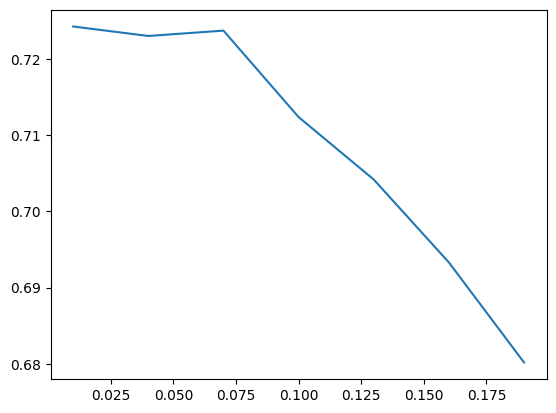

In [30]:
Geo2=[]
Learning_rate = [i for i in np.arange(0.01,0.2,0.03)]
geo_score = []
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
for i in Learning_rate:
    for train_index,test_index in kf.split(X_train, y_train):
        xtr,xvd=X_train[train_index],X_train[test_index]
        ytr,yvd=y_train[train_index],y_train[test_index]
        xtr_res,ytr_res=ros.fit_resample(xtr, ytr)
        gbc =GradientBoostingClassifier(n_estimators=100,learning_rate=i).fit(xtr_res,ytr_res)
        y_pred_test = gbc.predict(xvd).round()
        geo_score.append(geo(yvd, y_pred_test))
    Geo2.append(np.mean(geo_score))
plt.plot(Learning_rate,Geo2)